# Analyzing SOFC data (part 4)

## 4) Quantitative features
I began by analyzing electron affinity and d-electron count, which do appear to capture most of the variability. I also looked at ion radius, which appeared to have no effect. However, there are other features to consider and it may be worth revisiting the radii with a better model (built in part 2). I also found in part 3 that adding material family and sample type as dummy variables significantly decreases the mean squared error.

###Average vs parent features:
I should mention here that there are **two sets of quantitative features** in my data set. One, which is marked with an 'avg' prefix, corresponds to the average factor taking into account dopant ions in the material. For example, La_0.5 Sr_0.5 Ni O_3 would have an A-site radius of 0.5\*La + 0.5\*Sr. The parent ion in this material is lanthanum (for chemical reasons), so the parent A-site radius is simply 1\*La.

Until now, I have only considered the average set of features, as I suspected it would be more descriptive. In this notebook I will test that hypothesis and determine the most descriptive features within each set.

###Tolerance factor and critical radius:
These features are common metrics used with perovskites, especially with regard to ion migration through the crystal:

* Tolerance factor measures the mismatch of A-site and B-site radii
* Critical radius indicates the free area in a crystal through which oxide ions must travel

In [1]:
'''import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import pandas as pd
import time
%matplotlib inline
from sklearn import cross_validation
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
'''
from sofc_func import *
%matplotlib inline

In [2]:
# Import using pandas
df = pd.read_csv("data.csv")

# Clean out rows where there is no parent A or parent B

data = df[pd.notnull(df['A_par']) & pd.notnull(df['B_par']) & pd.notnull(df['d_star']) & pd.notnull(df['k_star']) 
             & pd.notnull(df['e affinity(B)']) & pd.notnull(df['d-electron count (B)'])]

pd.options.mode.chained_assignment = None

data = features(df)

data['dk_star'] = pd.Series(dk_star(data,1000), index=df.index)

In [3]:
f = df[pd.notnull(data['EA_A']) & pd.notnull(data['EA_B']) & pd.notnull(data['r_A'])
          & pd.notnull(data['r_B']) & pd.notnull(data['d_count_B']) & pd.notnull(data['avg_EA_A'])
          & pd.notnull(data['avg_EA_B']) & pd.notnull(data['avg_r_A']) & pd.notnull(data['avg_r_B'])
          & pd.notnull(data['avg_d_count_B']) & pd.notnull(data['dk_star'])]
X = f[ ['EA_A', 'EA_B', 'r_A', 'r_B', 'd_count_B', 'avg_EA_A', 'avg_EA_B', 'avg_r_A',
        'avg_r_B', 'avg_d_count_B', 'tol_factor', 'r_critical' ]]

y = f['dk_star']

###I will now perform recursive feature elimination (RFE) to determine the features that explain the most variance
Those features that explain the most variance will likely be the best features to use in my model

In [4]:
from sklearn.decomposition import FactorAnalysis
#model = make_pipeline(PolynomialFeatures(3), Ridge())
model = Ridge().fit(X,y)

selector = RFE(model, 2, step=1)
selector = selector.fit(X, y)

rank = []

for i, v in enumerate(X.columns.values):
    rank.append([v, int(selector.ranking_[i]) ] )
rank = np.array(rank)
print rank

[['EA_A' '8']
 ['EA_B' '4']
 ['r_A' '10']
 ['r_B' '1']
 ['d_count_B' '6']
 ['avg_EA_A' '9']
 ['avg_EA_B' '1']
 ['avg_r_A' '11']
 ['avg_r_B' '2']
 ['avg_d_count_B' '5']
 ['tol_factor' '3']
 ['r_critical' '7']]


####A few things to note:

* This feature elimination was done with a **linear** model, not a polynomial one. Thus, these are not the exact rankings of the features.
* B-cation factors all rank higher than A-cation factors. This suggests diffusion is affected primarily by choice of B-cation.
* Ranking of parent vs average factors is mixed
* Tolerance factor and critical radius (which use average factors as input) are in the middle

I will plot these features against D\*k\* and take a look at what model might represent them.

[]

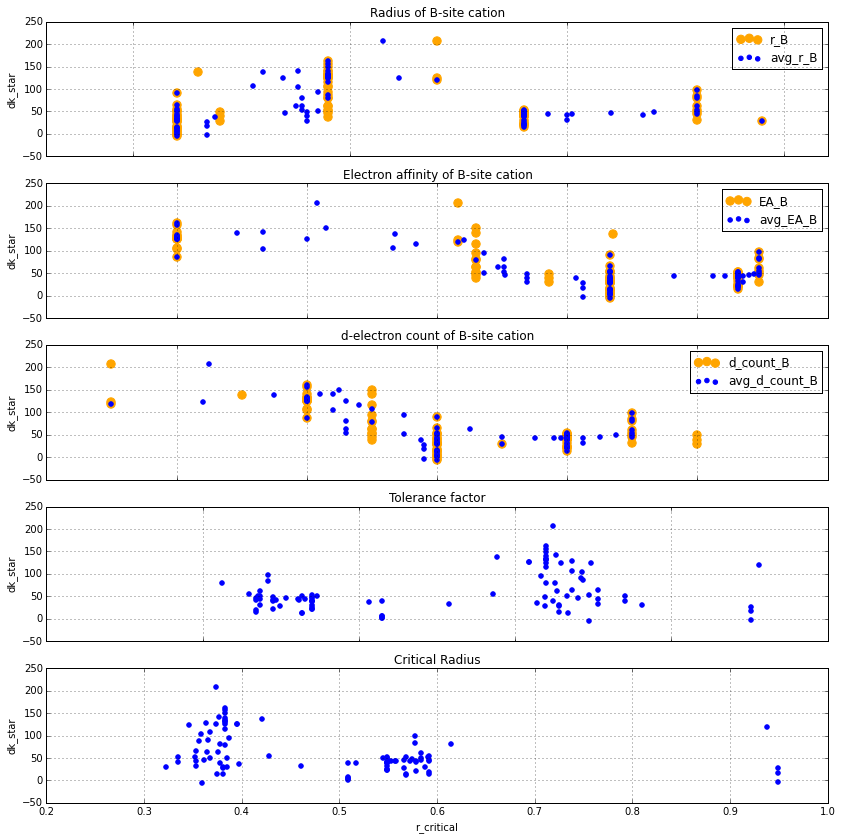

In [5]:
fig = plt.figure(figsize=(14,14))
ax1 = plt.subplot2grid((5,1), (0,0), colspan=1)
plt.title('Radius of B-site cation')
f.plot(kind='scatter', x='r_B', y='dk_star', label='r_B', color='orange', s=70, ax=ax1)
f.plot(kind='scatter', x='avg_r_B', y='dk_star', label='avg_r_B', color='blue', ax=ax1)

ax2 = plt.subplot2grid((5,1), (1,0), colspan=1)
plt.title('Electron affinity of B-site cation')
f.plot(kind='scatter', x='EA_B', y='dk_star', label='EA_B', color='orange', s=70, ax=ax2)
f.plot(kind='scatter', x='avg_EA_B', y='dk_star', label='avg_EA_B', color='blue', ax=ax2)

ax3 = plt.subplot2grid((5,1), (2,0), colspan=1)
plt.title('d-electron count of B-site cation')
plt.xlabel('d-electron count')
#plt.ylabel('D\*k\*')
f.plot(kind='scatter', x='d_count_B', y='dk_star', label='d_count_B', color='orange', s=70, ax=ax3)
f.plot(kind='scatter', x='avg_d_count_B', y='dk_star', label='avg_d_count_B', color='blue', ax=ax3)

ax4 = plt.subplot2grid((5,1), (3,0), colspan=1)
plt.title('Tolerance factor')
plt.xlabel('Tolerance factor')
plt.ylabel('D*k*')
f.plot(kind='scatter', x='tol_factor', y='dk_star', color='blue', ax=ax4)

ax5 = plt.subplot2grid((5,1), (4,0), colspan=1)
plt.title('Critical Radius')
plt.xlabel('r_critical')
plt.ylabel('D*k*')
f.plot(kind='scatter', x='r_critical', y='dk_star', color='blue', ax=ax5)


plt.plot()

Critical radius and tolerance factor may have a relationship, but the data are too clustered about a few regions to expect good predictive quality. Electron affinity, d-electron count, and to a lesser degree B-site radius all have much more distributed data and their trends appear clear.

I will continue using the latter 3 factors, despite B-site radius showing no usefulness in the first notebook.

###Average or parent factors?
One consideration is to determine how well a model can represent variation if it uses average or pure values of the factors. I will construct two models with the three above factors and determine which one is better. Leave-one-out CV will be used again here.

###Parent factors:

In [7]:
pure_x = np.array(X[['r_B', 'EA_B', 'd_count_B']])
pure_y = np.array([y]).T

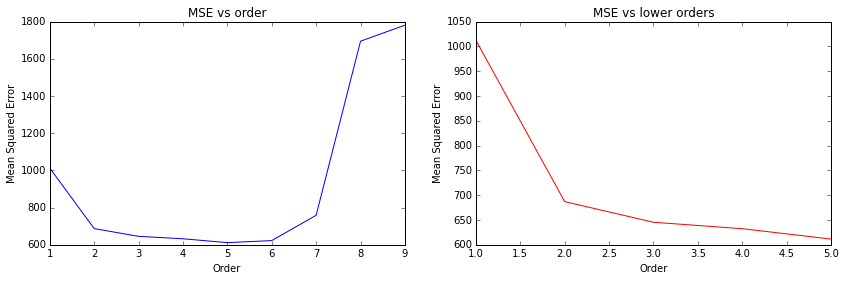

Polynomial order optimization executed in: 142.424177s


In [8]:
optimize_order(50, len(pure_y), 1, pure_x, pure_y, False)

5th order is again the optimum.

###Average model:

In [9]:
avg_x = np.array(X[['avg_r_B', 'avg_EA_B', 'avg_d_count_B']])
avg_y = np.array([y]).T

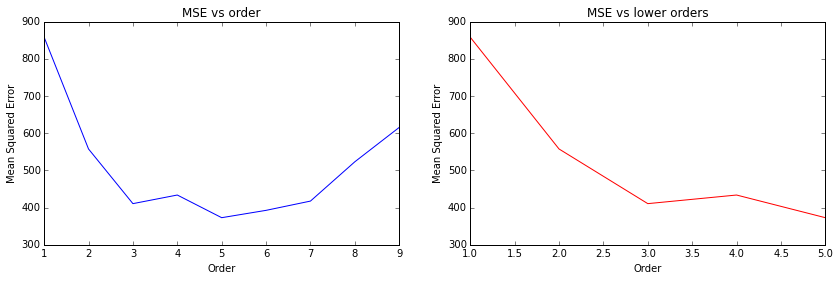

Polynomial order optimization executed in: 136.959813s


In [10]:
optimize_order(50, len(avg_y), 1, avg_x, avg_y, False)

###Comparison between pure and average models:

####Pure model score:

In [11]:
get_scores(50, 1,5,len(pure_y),pure_x,pure_y, False)

Average MSE of this model: 611.62615887
Standard deviation of MSE: 1.13686837722e-13


####Average model score:

In [12]:
get_scores(50, 1,5,len(avg_y),avg_x,avg_y, False)

Average MSE of this model: 372.888065967
Standard deviation of MSE: 7.36774916096e-14


##Conclusion:

Average model scores show much lower mean squared error. This is a somewhat obvious result given the scatterplots above because the average data has much higher resolution. Nonetheless, this is a good sanity check. I will use average features from this point on.

The **next notebook** will test:

**1)** EA_B, d-count, and r_B individually contribute to a fair portion of the variation (i.e. there is not overwhelming multicollinearity between them - I know there will be some)

**2)** The parameters I left out (i.e. the ones corresponding to the A-cation) don't explain very much variation and are correctly left from the model.

I should note that by choosing to remove 3 of these parameters (the average ones), I am somewhat disregarding what the recursive feature elimination (RFE) told me at the beginning. I am doing this because there is obviously a huge amount of multicollinearity associated with, for example, average radius and parent radius.